# 1. Get data

In [ ]:
import kagglehub

path = kagglehub.dataset_download("ashkhagan/figshare-brain-tumor-dataset")

print("Path to dataset files:", path)

# 2. Export from matlab

Dataset shapes:
X_tumor: (3064, 256, 256, 1)
Y_tumor_mask: (3064, 256, 256, 1)
Tumor labels: (3064,)
Unique labels: [0 1 2]


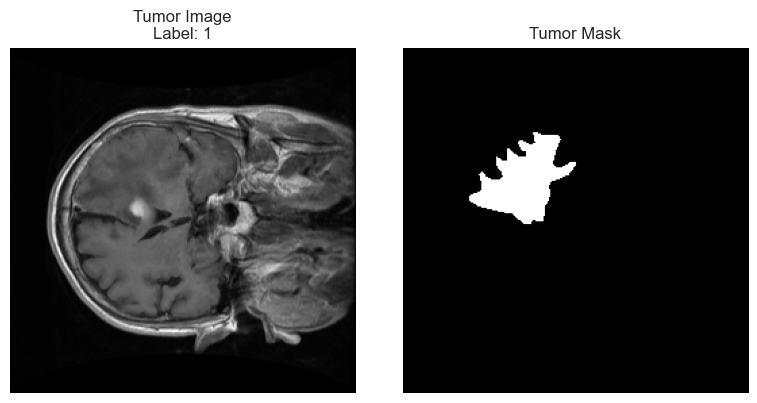

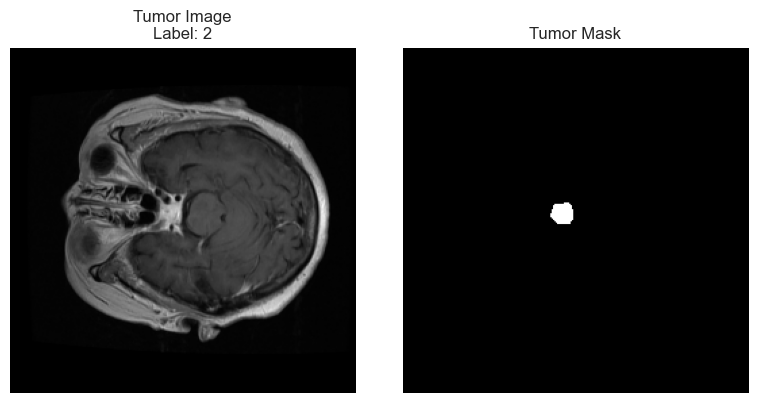

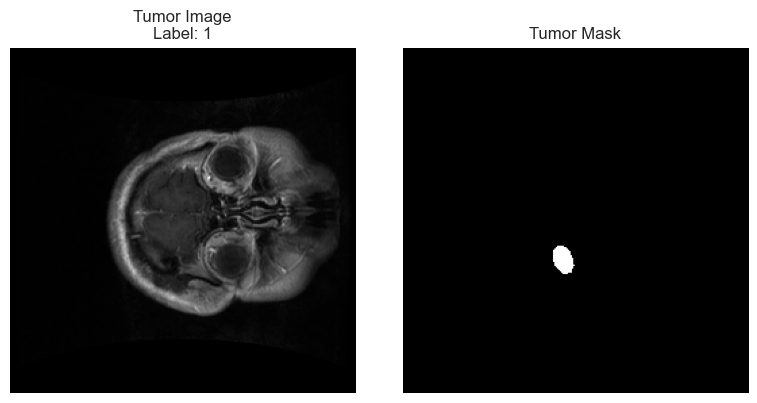

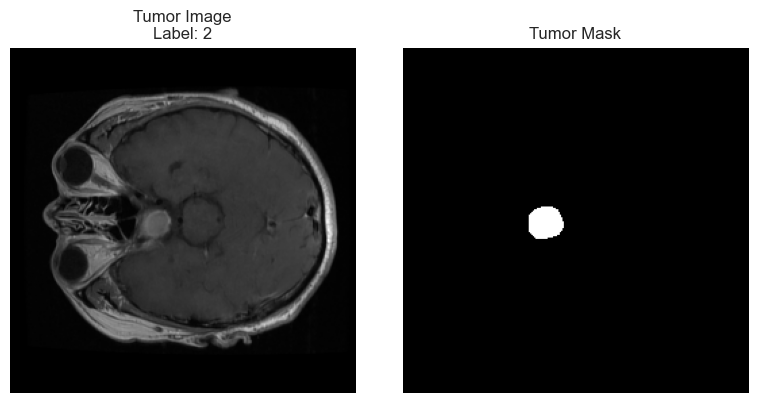

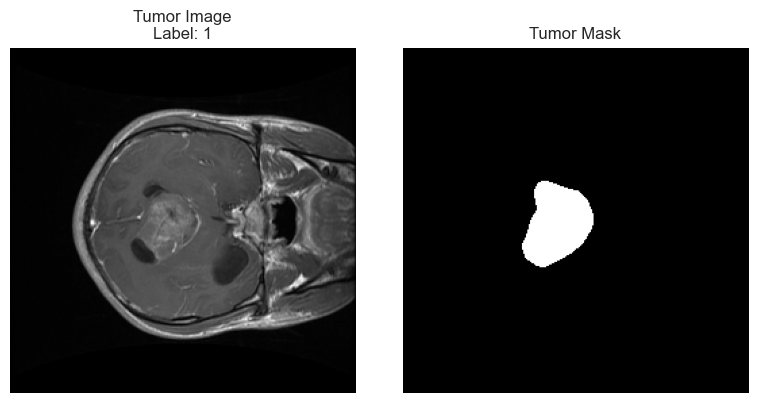

In [1]:
import random
import numpy as np
import h5py
import os
import cv2
import matplotlib.pyplot as plt

# path to dataset
# data_dir = "D:\\BACHELOR THESIS\\dataset\\ashkhagan\\figshare-brain-tumor-dataset\\versions\\1\\dataset\\data" # pt windows
data_dir = "/Users/horiaionescu/.cache/kagglehub/datasets/ashkhagan/figshare-brain-tumor-dataset/versions/1/dataset/data" # pt mac
total_images = 3064

X_tumor = []
Y_tumor_mask = []
tumor_labels = []


for i in range(1, total_images + 1):
    filename = str(i) + ".mat"
    file_path = os.path.join(data_dir, filename)

    # mat file using h5py (for matlab v7.3 files)
    with h5py.File(file_path, "r") as data:
        # image resize and normalize
        image = np.array(data["cjdata"]["image"])
        image = cv2.resize(image, (256, 256))  # 256x256
        image = image / 255.0  # normalize pixel val to be [0,1]
        X_tumor.append(image)

        # same goes for mask resize and threshold into binary img
        mask = np.array(data["cjdata"]["tumorMask"])
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 0).astype(np.uint8)  # this is conversion to binary img
        Y_tumor_mask.append(mask)

        # tumor label 1 -> meningioma  2 -> glioma  3 -> pituitary
        label = int(np.array(data["cjdata"]["label"])[0][0] - 1)
        tumor_labels.append(label)

# lists to numpy arr
# add extra channel dimension for compatibility with most deep learning models , this is grayscale
X_tumor = np.array(X_tumor).reshape(-1, 256, 256, 1)
Y_tumor_mask = np.array(Y_tumor_mask).reshape(-1, 256, 256, 1)
tumor_labels = np.array(tumor_labels)


print("Dataset shapes:")
print("X_tumor:", X_tumor.shape)
print("Y_tumor_mask:", Y_tumor_mask.shape)
print("Tumor labels:", tumor_labels.shape)
print("Unique labels:", np.unique(tumor_labels))


# visualize

num_samples = 5

sample_indices = random.sample(range(len(X_tumor)), num_samples)

for idx in sample_indices:
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(X_tumor[idx].squeeze(), cmap='gray')
    plt.title(f"Tumor Image\nLabel: {tumor_labels[idx]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Y_tumor_mask[idx].squeeze(), cmap='gray')
    plt.title("Tumor Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# 256x256x1 needed for segmentation
# for classification, we'll need 256x256x3 , 3 channel rgb

# 3. Preprocess

In [2]:
# resize 256x256x1 already done
# normalization already done
# grayscale as well, here we just do a check to ensure all are greyscale
# and padding to ensure uniformity

target_height = 256
target_width = 256

def check_and_pad(image, target_height, target_width):
    current_height, current_width = image.shape[:2]

    # return if image is already in required measurements
    if current_height == target_height and current_width == target_width:
        return image

    # padding calc
    pad_height = target_height - current_height
    pad_width = target_width - current_width

    if image.ndim == 3:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0)
    else:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)
    return padded_image


X_tumor_processed = []


for img in X_tumor:
    # convert to grayscale in case it doesnt have enough channels
    if img.ndim == 3 and img.shape[-1] != 1:
        # convert from [0,1] to [0,255] for cv2 manipulation
        img_8bit = (img * 255).astype(np.uint8)
        img_gray = cv2.cvtColor(img_8bit, cv2.COLOR_BGR2GRAY)
        # go back to [0,1] and expand dimensions to add channel dimension
        img_gray = img_gray.astype(np.float32) / 255.0
        img = np.expand_dims(img_gray, axis=-1)

    img_2d = img.squeeze()
    img_padded = check_and_pad(img_2d, target_height, target_width)
    img_final = np.expand_dims(img_padded, axis=-1)
    X_tumor_processed.append(img_final)

X_tumor_processed = np.array(X_tumor_processed)
print("Processed X_tumor shape:", X_tumor_processed.shape)

Processed X_tumor shape: (3064, 256, 256, 1)


# 4. Pytorch lightning module

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl

# dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images -> numpy array of shape (N, 256, 256, 1)
        masks -> numpy array of shape (N, 256, 256, 1)
        images and masks have same shape (and should have)
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # make images and masks torch tensors and squeeze channel dim if necessary
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)
        label = self.labels[idx]

        return image, label

# Lightning dataModule
class BrainTumorDataModule(pl.LightningDataModule):
    def __init__(self, images, labels, batch_size=16, val_split=0.1, test_split=0.2, num_workers=0):
        super().__init__()
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split
        self.num_workers = num_workers

    def setup(self, stage=None):
        # create the full version of the dataset
        full_dataset = BrainTumorDataset(self.images, self.labels)
        dataset_size = len(full_dataset)

        # split sizes
        test_size = int(self.test_split * dataset_size)
        val_size = int(self.val_split * (dataset_size - test_size))
        train_size = dataset_size - test_size - val_size

        # use generator with seed to ensure same items every run
        gen = torch.Generator().manual_seed(42)

        # this randomly splits the dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size],
            generator=gen
        )
        print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

    # this will be used for training
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)

    # .... for validation
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    # .... for testing
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

# set batch size and instantiate data module
batch_size = 16
data_module = BrainTumorDataModule(X_tumor_processed, tumor_labels ,batch_size=batch_size)
data_module.setup()

# initialize loaders
train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()
for batch in train_loader:
    images, labels = batch
    print("Batch images shape:", images.shape)  # should be (batch_size, 1, 256, 256)
    print("Batch labels shape:", labels.shape)      # same here
    break

Train size: 2207, Validation size: 245, Test size: 612
Batch images shape: torch.Size([16, 1, 256, 256])
Batch labels shape: torch.Size([16])


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl

# dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, images, masks, labels, transform=None):
        """
        images -> numpy array of shape (N, 256, 256, 1)
        masks -> numpy array of shape (N, 256, 256, 1)
        images and masks have same shape (and should have)
        labels -> numpy array of shape (N,)
        """
        self.images = images
        self.masks = masks
        self.labels = labels  # added for classification
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # # make images, masks and labels torch tensors and squeeze channel dim if necessary
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(self.masks[idx], dtype=torch.float32).permute(2, 0, 1)
        label = self.labels[idx]  # 0, 1, 2

        return image, mask, label


    # Lightning dataModule
class BrainTumorDataModule(pl.LightningDataModule):
    def __init__(self, images, masks, labels, batch_size=16, val_split=0.1, test_split=0.2, num_workers=0):
        super().__init__()
        self.images = images
        self.masks = masks
        self.labels = labels  # added labels here
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split
        self.num_workers = num_workers

    def setup(self, stage=None):
        # create the full version of the dataset, now includes labels
        full_dataset = BrainTumorDataset(self.images, self.masks, self.labels)
        dataset_size = len(full_dataset)

        # split sizes
        test_size = int(self.test_split * dataset_size)
        val_size = int(self.val_split * (dataset_size - test_size))
        train_size = dataset_size - test_size - val_size

        # use generator with seed to ensure same items every run
        gen = torch.Generator().manual_seed(42)

        # this randomly splits the dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size],
            generator = gen
        )
        print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

    # this will be used for training
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)

    # .... for validation
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    # .... for testing
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)


# instantiate data module, batch size already set
data_module = BrainTumorDataModule(X_tumor_processed, Y_tumor_mask, tumor_labels)
data_module.setup()

# initialize loaders
train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()
for batch in train_loader:
    images, masks, labels = batch  # technically, it should also include labels
    print("Batch images shape:", images.shape)  # should be (batch_size, 1, 256, 256)
    print("Batch masks shape:", masks.shape)    # same here
    print("Batch labels shape:", labels.shape)  # should be (batch_size,)
    break

# this shows how many samples from the test set are for each type of tumor
from collections import Counter
label_counts = Counter()

for images, masks, labels in test_loader:
    label_counts.update(labels.numpy())

for label in sorted(label_counts):
    print(f'Label {label} has {label_counts[label]} images in test set.')

Train size: 2207, Val size: 245, Test size: 612
Batch images shape: torch.Size([16, 1, 256, 256])
Batch masks shape: torch.Size([16, 1, 256, 256])
Batch labels shape: torch.Size([16])
Label 0 has 153 images in test set.
Label 1 has 281 images in test set.
Label 2 has 178 images in test set.


# 5. Model classification only training

In [4]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# setting seed again to ensure everything is the same every run !!!!!!
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
pl.seed_everything(42)
torch.cuda.manual_seed_all(42)  # for gpu usage
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# model
class FCNResNet50Lightning(pl.LightningModule):
    def __init__(self, num_classes=3, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        # 1) Backbone
        fcn = torchvision.models.segmentation.fcn_resnet50(pretrained=True)

        # Keep only the encoder: this is fcn.backbone
        self.encoder = fcn.backbone

        # 2) Classification head on top of encoder’s final feature map
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # → [B, 2048, 1, 1]
            nn.Flatten(),             # → [B, 2048]
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Ensure 3-channel if needed
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        # Pass through the ResNet50 encoder
        feats = self.encoder(x)["out"]
        # feats: [B, 2048, H/8, W/8] for FCN backbone

        # Apply classifier on the output
        logits = self.classifier(feats)
        return logits

    def training_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = F.cross_entropy(logits, labels)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)

        acc = (preds == labels).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


Seed set to 42


# 6. Train

In [17]:
# initialize model, trainer, then train again for 10 epochs
model = FCNResNet50Lightning()
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, datamodule=data_module)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Train size: 2207, Validation size: 245, Test size: 612



  | Name       | Type                    | Params | Mode 
---------------------------------------------------------------
0 | encoder    | IntermediateLayerGetter | 23.5 M | train
1 | classifier | Sequential              | 1.1 M  | train
---------------------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.235    Total estimated model params size (MB)
156       Modules in train mode
0         Modules in eval mode


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 138/138 [03:07<00:00,  0.74it/s, v_num=6, train_loss=0.268]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 138/138 [03:06<00:00,  0.74it/s, v_num=6, train_loss=0.410, val_loss=0.863, val_acc=0.800]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 138/138 [03:06<00:00,  0.74it/s, v_num=6, train_loss=0.229, val_loss=0.529, val_acc=0.800]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 138/138 [03:06<00:00,  0.74it/s, v_num=6, train_loss=0.340, val_loss=2.340, val_acc=0.510] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 138/138 [03:07<00:00,  0.74it/s, v_num=6, train_loss=0.652, val_loss=0.497, val_acc=0.816] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 138/138 [03:06<00:00,  0.74it/s, v_num=6, train_loss=0.151, val_loss=0.332, val_acc=0.869] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 138/138 [03:06<00:00,  0

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 138/138 [03:13<00:00,  0.71it/s, v_num=6, train_loss=0.0307, val_loss=0.251, val_acc=0.927]


# 7. Validation and test loss

In [18]:
# validation and test losses
model.eval()

trainer.validate(model, datamodule=data_module)

print("\n")

model.test_step = model.validation_step

trainer.test(model, datamodule=data_module)

Train size: 2207, Validation size: 245, Test size: 612
Validation DataLoader 0: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9265305995941162
        val_loss            0.2511615753173828
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Train size: 2207, Validation size: 245, Test size: 612


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 39/39 [00:16<00:00,  2.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9052287340164185
        val_loss            0.30329033732414246
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.30329033732414246, 'val_acc': 0.9052287340164185}]

# 8. Classification report

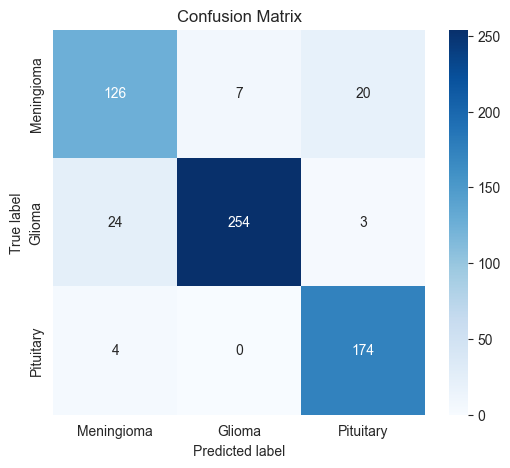

Classification Report:

              precision    recall  f1-score   support

  Meningioma     0.8182    0.8235    0.8208       153
      Glioma     0.9732    0.9039    0.9373       281
   Pituitary     0.8832    0.9775    0.9280       178

    accuracy                         0.9052       612
   macro avg     0.8915    0.9017    0.8954       612
weighted avg     0.9083    0.9052    0.9055       612



In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        # move to same device as model
        images = images.to(model.device)
        labels = labels.to(model.device)

        class_logits = model(images)

        preds = torch.argmax(class_logits, 1)

        y_true.append(labels.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ["Meningioma", "Glioma", "Pituitary"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

# accuracy, precision, recall, f1
print("Classification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4
))


# Save model

In [20]:
trainer.save_checkpoint("checkpoints/classification_alone_without_masks_0.90.ckpt")

# Incorporate segmentation, see how it can benefit or not from classification features

In [6]:
cls_only = FCNResNet50Lightning.load_from_checkpoint("checkpoints/classification_alone_without_masks_0.90.ckpt")

for name, p in cls_only.named_parameters():
    print(name, p.requires_grad)

encoder.conv1.weight True
encoder.bn1.weight True
encoder.bn1.bias True
encoder.layer1.0.conv1.weight True
encoder.layer1.0.bn1.weight True
encoder.layer1.0.bn1.bias True
encoder.layer1.0.conv2.weight True
encoder.layer1.0.bn2.weight True
encoder.layer1.0.bn2.bias True
encoder.layer1.0.conv3.weight True
encoder.layer1.0.bn3.weight True
encoder.layer1.0.bn3.bias True
encoder.layer1.0.downsample.0.weight True
encoder.layer1.0.downsample.1.weight True
encoder.layer1.0.downsample.1.bias True
encoder.layer1.1.conv1.weight True
encoder.layer1.1.bn1.weight True
encoder.layer1.1.bn1.bias True
encoder.layer1.1.conv2.weight True
encoder.layer1.1.bn2.weight True
encoder.layer1.1.bn2.bias True
encoder.layer1.1.conv3.weight True
encoder.layer1.1.bn3.weight True
encoder.layer1.1.bn3.bias True
encoder.layer1.2.conv1.weight True
encoder.layer1.2.bn1.weight True
encoder.layer1.2.bn1.bias True
encoder.layer1.2.conv2.weight True
encoder.layer1.2.bn2.weight True
encoder.layer1.2.bn2.bias True
encoder.laye

In [11]:
# import pytorch_lightning as pl
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision
#
# # setting seed again to ensure everything is the same every run !!!!!!
# random.seed(42)
# np.random.seed(42)
# torch.manual_seed(42)
# pl.seed_everything(42)
# torch.cuda.manual_seed_all(42)  # for gpu usage
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# model
class FCNResNet50LightningSeg(pl.LightningModule):
    def __init__(self, num_classes=3, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        # 1) Backbone
        fcn = torchvision.models.segmentation.fcn_resnet50(pretrained=True)

        # Keep only the encoder: this is fcn.backbone
        self.encoder = fcn.backbone

        # 2) Classification head on top of encoder’s final feature map
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # → [B, 2048, 1, 1]
            nn.Flatten(),             # → [B, 2048]
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

        self.seg_decoder = fcn.classifier

        self.seg_decoder[4] = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x):
        # Ensure 3-channel if needed
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        # Pass through the ResNet50 encoder
        feats = self.encoder(x)["out"]

        seg_logits = self.seg_decoder(feats)
        seg_out    = torch.sigmoid(seg_logits)
        seg_out = F.interpolate(
            seg_out,
            size=masks.shape[2:],
            mode="bilinear",
            align_corners=False
        )

        return seg_out

    def dice_loss(self, preds, targets, epsilon=1e-6):
        intersection = (preds * targets).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = 2.0 * intersection / (union + epsilon)
        return 1 - dice.mean()  # dice loss wil be 1 - current dice coef

    # final combined loss function (BCE + Dice loss with equal contribution)
    def combined_loss(self, preds, masks, bce_weight=0.5, dice_weight=0.5):
        # binary cross entropy
        bce_loss = F.binary_cross_entropy(preds, masks)
        # dice
        dice_loss = self.dice_loss(preds, masks)
        # final loss
        return bce_weight * bce_loss + dice_weight * dice_loss

    # training step with logging
    def training_step(self, batch, batch_idx):
        images, masks, _ = batch
        preds = self.forward(images)
        loss = self.combined_loss(preds, masks)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    # validation step with logging
    def validation_step(self, batch, batch_idx):
        images, masks, _ = batch
        preds = self.forward(images)
        loss = self.combined_loss(preds, masks)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


# Train

In [12]:
cls_frozen = FCNResNet50LightningSeg()

cls_frozen.encoder = cls_only.encoder

for p in cls_frozen.encoder.parameters():
    p.requires_grad = False

for p in cls_frozen.classifier.parameters():
    p.requires_grad = False

for name, p in cls_frozen.named_parameters():
    print(name, p.requires_grad)


trainer = pl.Trainer(max_epochs=10)
trainer.fit(cls_frozen, datamodule=data_module)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


encoder.conv1.weight False
encoder.bn1.weight False
encoder.bn1.bias False
encoder.layer1.0.conv1.weight False
encoder.layer1.0.bn1.weight False
encoder.layer1.0.bn1.bias False
encoder.layer1.0.conv2.weight False
encoder.layer1.0.bn2.weight False
encoder.layer1.0.bn2.bias False
encoder.layer1.0.conv3.weight False
encoder.layer1.0.bn3.weight False
encoder.layer1.0.bn3.bias False
encoder.layer1.0.downsample.0.weight False
encoder.layer1.0.downsample.1.weight False
encoder.layer1.0.downsample.1.bias False
encoder.layer1.1.conv1.weight False
encoder.layer1.1.bn1.weight False
encoder.layer1.1.bn1.bias False
encoder.layer1.1.conv2.weight False
encoder.layer1.1.bn2.weight False
encoder.layer1.1.bn2.bias False
encoder.layer1.1.conv3.weight False
encoder.layer1.1.bn3.weight False
encoder.layer1.1.bn3.bias False
encoder.layer1.2.conv1.weight False
encoder.layer1.2.bn1.weight False
encoder.layer1.2.bn1.bias False
encoder.layer1.2.conv2.weight False
encoder.layer1.2.bn2.weight False
encoder.layer1


  | Name        | Type                    | Params | Mode 
----------------------------------------------------------------
0 | encoder     | IntermediateLayerGetter | 23.5 M | eval 
1 | classifier  | Sequential              | 1.1 M  | train
2 | seg_decoder | FCNHead                 | 9.4 M  | train
----------------------------------------------------------------
9.4 M     Trainable params
24.6 M    Non-trainable params
34.0 M    Total params
135.990   Total estimated model params size (MB)
13        Modules in train mode
149       Modules in eval mode


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 138/138 [01:27<00:00,  1.59it/s, v_num=8, train_loss=0.458]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 138/138 [01:29<00:00,  1.55it/s, v_num=8, train_loss=0.454, val_loss=0.485]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 138/138 [01:29<00:00,  1.53it/s, v_num=8, train_loss=0.488, val_loss=0.475]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s, v_num=8, train_loss=0.470, val_loss=0.474]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s, v_num=8, train_loss=0.466, val_loss=0.469]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 138/138 [01:28<00:00,  1.55it/s, v_num=8, train_loss=0.500, val_loss=0.466]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 138/138 [01:28<00:00,  1.56it/s, v_num=8, train_loss=0.456, val_loss=0.467]
Validation: |          | 0

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 138/138 [01:37<00:00,  1.41it/s, v_num=8, train_loss=0.375, val_loss=0.464]


# Dice coef

In [16]:
cls_frozen.eval()

# dice coefficient function, follows same structure as the loss
def dice_coef(pred, target, thr=0.65, eps=1e-6):
    pred_bin = (pred > thr).float()
    B = pred_bin.shape[0]
    p_flat = pred_bin.view(B, -1)
    t_flat = target.view(B, -1)
    inter  = (p_flat * t_flat).sum(dim=1)
    summ   = p_flat.sum(dim=1) + t_flat.sum(dim=1)
    dice   = (2*inter + eps) / (summ + eps)
    return dice.mean().item()


dice_scores = []

with torch.no_grad():
    for imgs, masks, *_ in test_loader:
        imgs  = imgs.to(cls_frozen.device)
        masks = masks.to(cls_frozen.device)
        seg_out = cls_frozen(imgs)
        dice_scores.append(dice_coef(seg_out, masks))

print("Cls frozen then segmentation model dice at same threshold ", sum(dice_scores)/len(dice_scores))

Cls frozen then segmentation model dice at same threshold  0.12687296983905327
